In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn

In [2]:
#load our train dataset.
train = pd.read_csv("~/datasets/mnist/train.csv")

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#Splitting train dataset into X and Y.Normalizing it by dividing it with 255
X = train.iloc[:,1:].values / 255
Y = train.iloc[:,0].values

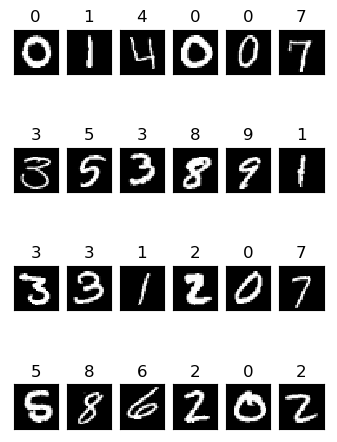

In [5]:
#visulaizing numbers in our dataset.
r = 4
c = 6
fig=plt.figure(figsize=(r, c),dpi=100)
for i in range(1, r*c+1):
    img = X[i].reshape(28,28)
    ax = fig.add_subplot(r, c, i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.title.set_text(Y[i])
    
    plt.imshow(img,cmap='gray')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

trn_x,val_x,trn_y,val_y = train_test_split(X,Y,test_size=0.2)

In [7]:
import mxnet as mx
from mxnet import nd, gluon, autograd
from mxnet.gluon import nn

batch_size = 100
train_iter = mx.io.NDArrayIter(trn_x, trn_y, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(val_x, val_y, batch_size)

In [8]:
device = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0)

In [9]:
data = mx.sym.var('data')

In [10]:
# The first fully-connected layer and the corresponding activation function
fc1  = mx.sym.FullyConnected(data=data, num_hidden=784)
act1 = mx.sym.Activation(data=fc1, act_type="relu")

# The second fully-connected layer and the corresponding activation function
fc2  = mx.sym.FullyConnected(data=act1, num_hidden = 64)
act2 = mx.sym.Activation(data=fc2, act_type="relu")

# MNIST has 10 classes
fc3  = mx.sym.FullyConnected(data=act2, num_hidden=10)
# Softmax with cross entropy loss
mlp  = mx.sym.SoftmaxOutput(data=fc3, name='softmax')

In [11]:
import logging
logging.getLogger().setLevel(logging.INFO)  # logging to stdout

mlp_model = mx.mod.Module(symbol=mlp, context=device)

mlp_model.fit(train_iter,  # train data
              eval_data=val_iter,  # validation data
              optimizer='adam',
              optimizer_params={'learning_rate':0.01},  # use fixed learning rate
              eval_metric=['acc'],
              batch_end_callback = mx.callback.Speedometer(batch_size, 100),
              num_epoch=10)

INFO:root:Epoch[0] Batch [0-100]	Speed: 67251.54 samples/sec	accuracy=0.823465
INFO:root:Epoch[0] Batch [100-200]	Speed: 75141.42 samples/sec	accuracy=0.934200
INFO:root:Epoch[0] Batch [200-300]	Speed: 81053.27 samples/sec	accuracy=0.941900
INFO:root:Epoch[0] Train-accuracy=0.904643
INFO:root:Epoch[0] Time cost=0.582
INFO:root:Epoch[0] Validation-accuracy=0.949762
INFO:root:Epoch[1] Batch [0-100]	Speed: 87854.10 samples/sec	accuracy=0.957723
INFO:root:Epoch[1] Batch [100-200]	Speed: 81866.75 samples/sec	accuracy=0.957000
INFO:root:Epoch[1] Batch [200-300]	Speed: 85604.16 samples/sec	accuracy=0.961900
INFO:root:Epoch[1] Train-accuracy=0.958304
INFO:root:Epoch[1] Time cost=0.401
INFO:root:Epoch[1] Validation-accuracy=0.961190
INFO:root:Epoch[2] Batch [0-100]	Speed: 86527.77 samples/sec	accuracy=0.968515
INFO:root:Epoch[2] Batch [100-200]	Speed: 83152.67 samples/sec	accuracy=0.970800
INFO:root:Epoch[2] Batch [200-300]	Speed: 82898.92 samples/sec	accuracy=0.966300
INFO:root:Epoch[2] Train-

In [12]:
pred = mlp_model.predict(val_iter)

In [13]:
predictions = []

for p in pred.asnumpy():
    predictions.append(np.argmax(p,axis=0))

In [15]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(val_y,predictions)

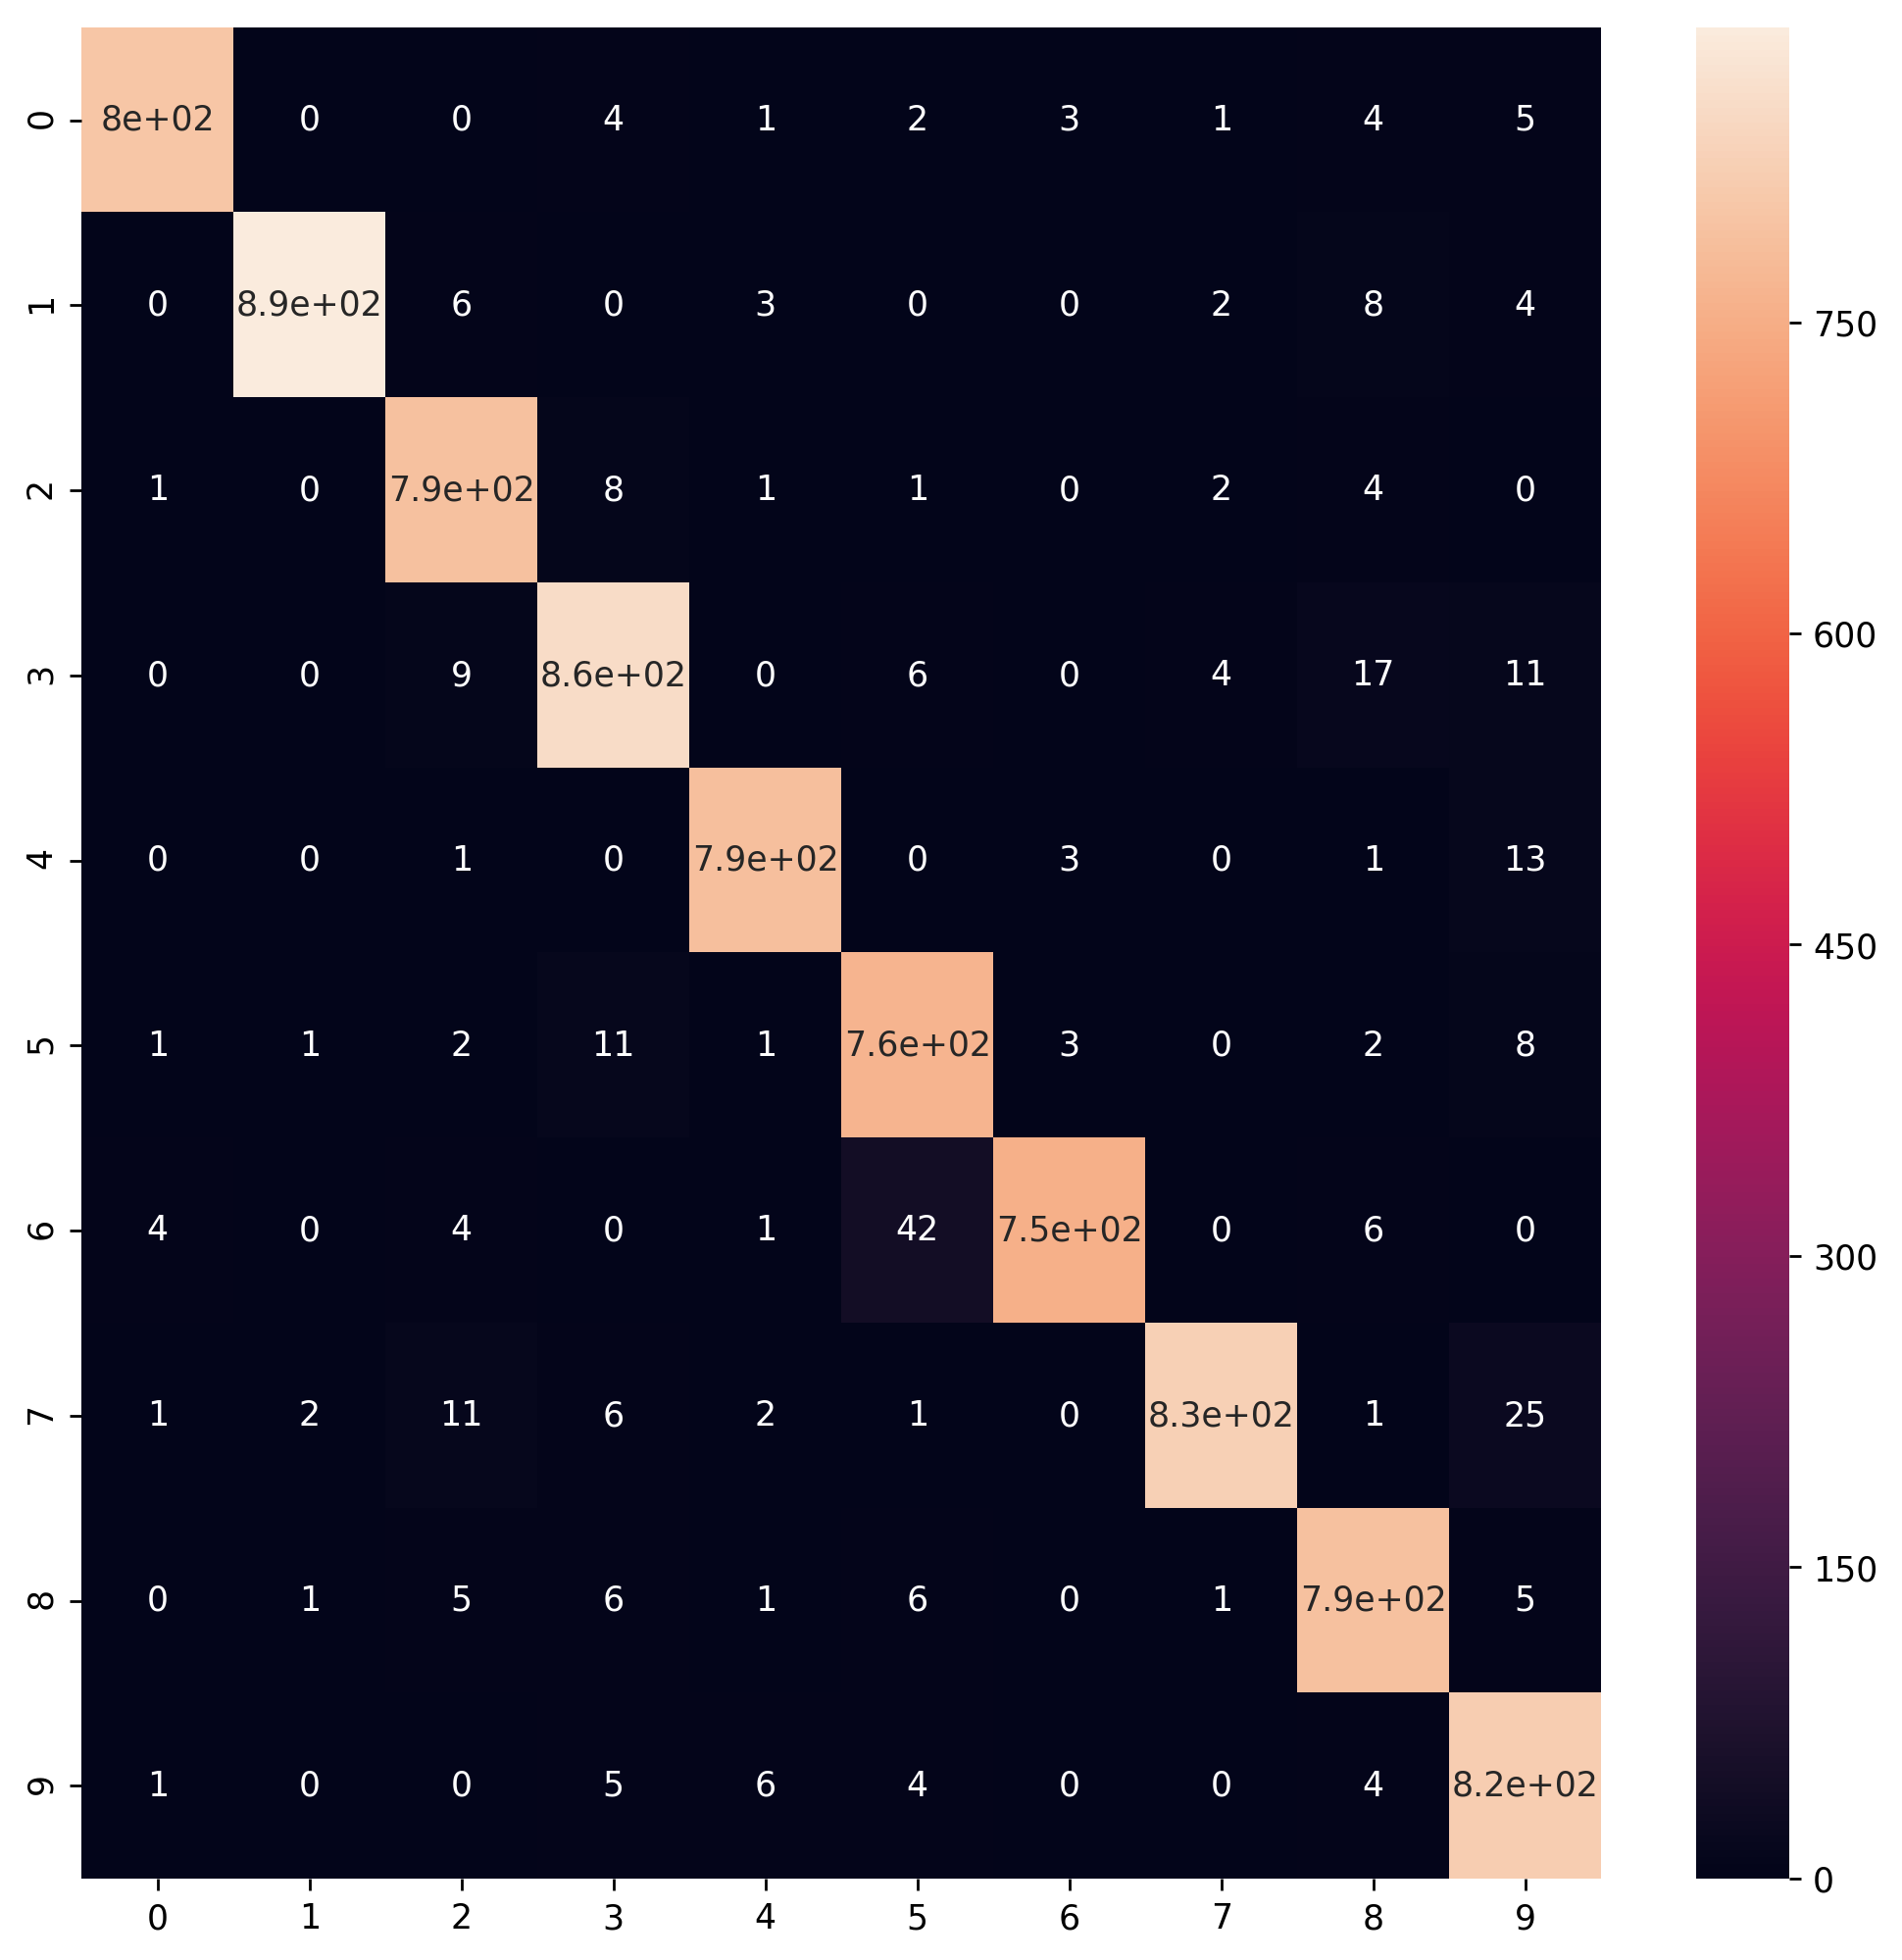

In [16]:
logging.getLogger().setLevel(logging.WARNING)

plt.figure(figsize = (10,10),dpi=250)
seaborn.heatmap(cm,annot=True)

In [18]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(val_y,predictions)

print("Accuracy:",acc*100,"%")

Accuracy: 96.369047619 %
